<img src="images/ScDo-Bandeau_Lingua_Technologies.png" style="width: 100%;float:center;"/>

<h1 style="font-size:250%;text-align:center">Évolution temporelle de la</h1>
<h1 style="font-size:250%;text-align:center">pandémie de la COVID-19 (SARS-CoV-2)</h1>
<h4 style="font-size:150%;text-align:center">par Claude COULOMBE</h4>
<h5 style="font-size:100%;text-align:center">PhD, scientifique de données, consultant Lingua Technologies</h5>


<img src="images/ScDo-pandas_logo.png" width=400 />

Pour contrer l'anxiété de la pandémie de COVID-19, rien de mieux que d'agir. J'ai donc préparé un petit carnet Web Python, prétexte pour un petit exercice d'exploration de données avec Pandas.

### Importation des bibliothèques utilisées

In [494]:
# Importation des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline


## Données

### Dépôt de données ouvertes de la COVID-19 - Johns Hopkins University

https://github.com/CSSEGISandData/COVID-19

<img src="" style="width: 100%;float:center;"/>

**Note** : Les données contenues dans le répertoire DATA doivent être mise à jour régulièrement pour refléter l'évolution de la pandémie dans le temps. 


### Lecture des données

Nous nous intéressons au fichier `time_series_covid19_confirmed_global.csv` qui contient les données sur les cas confirmés de COVID-19

wget --no-check-certificate https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv?raw=True -O time_series_covid19_confirmed_global.csv

In [495]:
# Note - bonne pratique de postfixer les Dataframe par _df (Rappel: Python n'est pas typé)
series_chronologiques_COVID19_df = pd.read_csv('DATA/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',sep=',')


## Exploration des données

In [496]:
series_chronologiques_COVID19_df.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/30/21,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,158056,158084,158107,158189,158183,158205,158245,158275,158300,158309
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,208899,210224,210224,210885,210885,212021,212021,213257,214905,214905
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,218037,218432,218818,219159,219532,219953,220415,220825,221316,221742
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,23122,23740,23740,23740,24502,24802,25289,25289,26408,26408
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,79871,81593,82398,82920,83764,84666,86636,87625,88775,89251


In [497]:
series_chronologiques_COVID19_df.tail()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/30/21,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22
275,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,...,1714742,1731257,1746092,1763040,1778976,1800704,1817721,1843563,1859841,1876394
276,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,469748,469748,469748,469748,469748,471090,471414,471414,471414,471414
277,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,10126,10126,10127,10130,10138,10143,10146,10152,10159,10178
278,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,249193,254274,257948,259677,261221,265479,269991,274087,278276,281576
279,NaN,Zimbabwe,-19.015438,29.154857,0,0,0,0,0,0,...,211728,213258,214214,214214,216087,217678,219057,220178,221282,221918


### Afficher les propriétés globales du tableau de données / DataFrame

Sa forme, les structures de données sous-jacentes et une description statistiques des variables numériques

In [498]:
series_chronologiques_COVID19_df.shape


(280, 722)

In [499]:
series_chronologiques_COVID19_df.columns


Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '12/30/21', '12/31/21', '1/1/22', '1/2/22', '1/3/22', '1/4/22',
       '1/5/22', '1/6/22', '1/7/22', '1/8/22'],
      dtype='object', length=722)

In [500]:
nbr_jours = len(series_chronologiques_COVID19_df.columns) - 4
nbr_jours


718

In [501]:
series_chronologiques_COVID19_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Columns: 722 entries, Province/State to 1/8/22
dtypes: float64(2), int64(718), object(2)
memory usage: 1.5+ MB


In [502]:
series_chronologiques_COVID19_df.describe()


,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,12/30/21,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22
count,278.000000,278.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,...,2.800000e+02,2.800000e+02,2.800000e+02,2.800000e+02,2.800000e+02,2.800000e+02,2.800000e+02,2.800000e+02,2.800000e+02,2.800000e+02
mean,20.156042,21.788955,1.989286,2.339286,3.360714,5.121429,7.564286,10.453571,19.921429,22.025000,...,1.023344e+06,1.029309e+06,1.033329e+06,1.036429e+06,1.045438e+06,1.054512e+06,1.063466e+06,1.072465e+06,1.082748e+06,1.089970e+06
std,25.283318,76.200169,26.590143,26.687678,33.225879,46.244243,64.627991,87.077220,213.666694,214.980193,...,4.322320e+06,4.349035e+06,4.359429e+06,4.374029e+06,4.432604e+06,4.476926e+06,4.514721e+06,4.559675e+06,4.611731e+06,4.639272e+06
min,-51.796300,-178.116500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.643279,-37.713675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.838750e+03,3.981750e+03,4.226250e+03,4.226250e+03,4.274750e+03,4.427000e+03,4.470000e+03,5.481750e+03,5.481750e+03,5.481750e+03
50%,21.517170,20.921188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.707450e+04,4.707450e+04,4.707450e+04,4.707450e+04,4.707450e+04,4.852150e+04,4.852150e+04,5.022350e+04,5.115200e+04,5.116100e+04
75%,40.393350,84.992575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.631392e+05,4.645612e+05,4.658085e+05,4.662142e+05,4.680545e+05,4.705850e+05,4.714190e+05,4.717288e+05,4.717288e+05,4.717288e+05
max,71.706900,178.065000,444.000000,444.000000,549.000000,761.000000,1058.000000,1423.000000,3554.000000,3554.000000,...,5.426987e+07,5.474238e+07,5.485882e+07,5.510700e+07,5.627838e+07,5.707756e+07,5.770087e+07,5.848770e+07,5.938853e+07,5.976722e+07


### Examen de la distribution des données et des attributs

In [503]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from pandas.api.types import is_string_dtype, is_numeric_dtype 

NBR_MAX_ATTRIBUTS_AFFICHES = 53

# Pour chaque attribut ou colonne d'un tableau de données / DataFrame
# Créer une boîte à moustaches, un histogramme ou une liste de valeurs possibles

def examen_distributions_attributs(un_dataframe):
    for attribut in un_dataframe.columns:
        # Afficher le type d'attribut
        print("-"*90)
        print("Attribut:",attribut,", Type:",un_dataframe.dtypes[attribut])
        # Si c'est un attribut catégoriel alors lister toutes les valeurs possibles
        if is_string_dtype(un_dataframe[attribut]):
            attributs_uniques = list(un_dataframe[attribut].unique())
            print("Nombre d'attributs_uniques:",len(attributs_uniques))
            if len(attributs_uniques) > NBR_MAX_ATTRIBUTS_AFFICHES:
                print("Affichage des " + str(NBR_MAX_ATTRIBUTS_AFFICHES) + " premières valeurs:")
                print(attributs_uniques[:NBR_MAX_ATTRIBUTS_AFFICHES])
            else:
                print(attributs_uniques)
                print("\nun_dataframe.groupby('"+attribut+"').size()\n",un_dataframe.groupby(attribut).size())
        if is_numeric_dtype(un_dataframe[attribut]):
            _ = un_dataframe.boxplot(attribut, figsize=(2, 3))
            plt.show()
            print()
            plt.close()
            _ = un_dataframe[attribut].plot(kind='hist',figsize=(2, 3))
            plt.show()
    print("-"*90)


In [504]:
# examen_distributions_attributs(series_chronologiques_COVID19_df)


### Retrait d'attributs «superflus»

Puisque nous nous intéressons à l'évolution du nombre de malades dans le temps, certains attributs (colonnes du tableau de données) sont superflus ou «inutiles» et alourdissent notre analyse.

Ci-dessous une liste d'attributs à retirer:

In [505]:
attributs_a_retirer = ["Lat","Long"]


Retirer les attributs «superflus» avec la fonction `.drop()`

In [506]:
series_chronologiques_COVID19_df = series_chronologiques_COVID19_df.drop(attributs_a_retirer,axis='columns')


In [507]:
series_chronologiques_COVID19_df.head()


,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,12/30/21,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,158056,158084,158107,158189,158183,158205,158245,158275,158300,158309
1,NaN,Albania,0,0,0,0,0,0,0,0,...,208899,210224,210224,210885,210885,212021,212021,213257,214905,214905
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,218037,218432,218818,219159,219532,219953,220415,220825,221316,221742
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,23122,23740,23740,23740,24502,24802,25289,25289,26408,26408
4,NaN,Angola,0,0,0,0,0,0,0,0,...,79871,81593,82398,82920,83764,84666,86636,87625,88775,89251


### Modification du format des dates

Pour l'affichage de date selon la norme des pays francophones.

In [508]:
new_columns = ['Province/State','Country/Region']
for date_raw in series_chronologiques_COVID19_df.columns:
    if not date_raw in ['Province/State','Country/Region']:
        split_date = date_raw.split("/")
        new_date = split_date[1]+"/"+split_date[0]+"/"+"20"+split_date[2]
        # print(new_date)
        new_columns.append(new_date)
    
series_chronologiques_COVID19_df.columns = new_columns
series_chronologiques_COVID19_df


,Province/State,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,...,30/12/2021,31/12/2021,1/1/2022,2/1/2022,3/1/2022,4/1/2022,5/1/2022,6/1/2022,7/1/2022,8/1/2022
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,158056,158084,158107,158189,158183,158205,158245,158275,158300,158309
1,NaN,Albania,0,0,0,0,0,0,0,0,...,208899,210224,210224,210885,210885,212021,212021,213257,214905,214905
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,218037,218432,218818,219159,219532,219953,220415,220825,221316,221742
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,23122,23740,23740,23740,24502,24802,25289,25289,26408,26408
4,NaN,Angola,0,0,0,0,0,0,0,0,...,79871,81593,82398,82920,83764,84666,86636,87625,88775,89251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,NaN,Vietnam,0,2,2,2,2,2,2,2,...,1714742,1731257,1746092,1763040,1778976,1800704,1817721,1843563,1859841,1876394
276,NaN,West Bank and Gaza,0,0,0,0,0,0,0,0,...,469748,469748,469748,469748,469748,471090,471414,471414,471414,471414
277,NaN,Yemen,0,0,0,0,0,0,0,0,...,10126,10126,10127,10130,10138,10143,10146,10152,10159,10178
278,NaN,Zambia,0,0,0,0,0,0,0,0,...,249193,254274,257948,259677,261221,265479,269991,274087,278276,281576


### Quels sont le différents pays et / ou états que l'on trouve dans les données?

In [509]:
print(list(series_chronologiques_COVID19_df['Province/State'].unique()))


[nan, 'Australian Capital Territory', 'New South Wales', 'Northern Territory', 'Queensland', 'South Australia', 'Tasmania', 'Victoria', 'Western Australia', 'Alberta', 'British Columbia', 'Diamond Princess', 'Grand Princess', 'Manitoba', 'New Brunswick', 'Newfoundland and Labrador', 'Northwest Territories', 'Nova Scotia', 'Nunavut', 'Ontario', 'Prince Edward Island', 'Quebec', 'Repatriated Travellers', 'Saskatchewan', 'Yukon', 'Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning', 'Macau', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Unknown', 'Xinjiang', 'Yunnan', 'Zhejiang', 'Faroe Islands', 'Greenland', 'French Guiana', 'French Polynesia', 'Guadeloupe', 'Martinique', 'Mayotte', 'New Caledonia', 'Reunion', 'Saint Barthelemy', 'Saint Pierre and Miquelon', 'St Martin'

In [510]:
print(list(series_chronologiques_COVID19_df['Country/Region'].unique()))


['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indones

#### Par exemple, examinons les données pour les différents états et régions des États-Unis.

In [511]:
series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']=="US"]


,Province/State,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,...,30/12/2021,31/12/2021,1/1/2022,2/1/2022,3/1/2022,4/1/2022,5/1/2022,6/1/2022,7/1/2022,8/1/2022
255,NaN,US,1,1,2,2,5,5,5,6,...,54269867,54742382,54858824,55106998,56278376,57077565,57700873,58487697,59388529,59767221


#### Maintenant, examinons les données pour les différentes provinces canadiennes.

In [512]:
series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']=="Canada"]


,Province/State,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,...,30/12/2021,31/12/2021,1/1/2022,2/1/2022,3/1/2022,4/1/2022,5/1/2022,6/1/2022,7/1/2022,8/1/2022
39,Alberta,Canada,0,0,0,0,0,0,0,0,...,361623,361623,361623,361623,361623,379374,384126,388995,395252,395252
40,British Columbia,Canada,0,0,0,0,0,0,1,1,...,251054,254849,254849,254849,254849,266710,270508,273731,276875,276875
41,Diamond Princess,Canada,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,Grand Princess,Canada,0,0,0,0,0,0,0,0,...,13,13,13,13,13,13,13,13,13,13
43,Manitoba,Canada,0,0,0,0,0,0,0,0,...,78606,80096,80096,80096,85507,87263,89050,91587,94850,94850
44,New Brunswick,Canada,0,0,0,0,0,0,0,0,...,13590,14272,14272,14272,16820,17566,18345,19017,19857,20278
45,Newfoundland and Labrador,Canada,0,0,0,0,0,0,0,0,...,3724,3724,4155,4155,5582,6075,6554,7057,7537,7537
46,Northwest Territories,Canada,0,0,0,0,0,0,0,0,...,2187,2229,2229,2229,2229,2419,2495,2652,2801,2801
47,Nova Scotia,Canada,0,0,0,0,0,0,0,0,...,17127,17745,18454,19638,20658,21678,21678,22520,23265,23265
48,Nunavut,Canada,0,0,0,0,0,0,0,0,...,765,803,803,875,891,900,900,942,977,977


### Création d'une entrée supplémentaire spécifique pour le Québec (avec accent aigu) 

In [513]:

quebec_df = series_chronologiques_COVID19_df[(series_chronologiques_COVID19_df['Country/Region']=="Canada") & 
                                (series_chronologiques_COVID19_df['Province/State']=="Quebec")]

quebec_df.loc[51,'Country/Region'] = 'Québec'
quebec_df.loc[51,'Province/State'] = np.nan

series_chronologiques_COVID19_df = series_chronologiques_COVID19_df.append(quebec_df , ignore_index=True)
series_chronologiques_COVID19_df


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Province/State,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,...,30/12/2021,31/12/2021,1/1/2022,2/1/2022,3/1/2022,4/1/2022,5/1/2022,6/1/2022,7/1/2022,8/1/2022
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,158056,158084,158107,158189,158183,158205,158245,158275,158300,158309
1,NaN,Albania,0,0,0,0,0,0,0,0,...,208899,210224,210224,210885,210885,212021,212021,213257,214905,214905
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,218037,218432,218818,219159,219532,219953,220415,220825,221316,221742
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,23122,23740,23740,23740,24502,24802,25289,25289,26408,26408
4,NaN,Angola,0,0,0,0,0,0,0,0,...,79871,81593,82398,82920,83764,84666,86636,87625,88775,89251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,NaN,West Bank and Gaza,0,0,0,0,0,0,0,0,...,469748,469748,469748,469748,469748,471090,471414,471414,471414,471414
277,NaN,Yemen,0,0,0,0,0,0,0,0,...,10126,10126,10127,10130,10138,10143,10146,10152,10159,10178
278,NaN,Zambia,0,0,0,0,0,0,0,0,...,249193,254274,257948,259677,261221,265479,269991,274087,278276,281576
279,NaN,Zimbabwe,0,0,0,0,0,0,0,0,...,211728,213258,214214,214214,216087,217678,219057,220178,221282,221918


### Regroupement des données des états et provinces
**Note** : Pour avoir un total par pays, nous allons regrouper les états et les provinces d'un même pays. Utilisation des fonctions `.groupby()` et `.sum()`. Aussi `.reset_index()`

In [514]:
series_chronologiques_COVID19_df = series_chronologiques_COVID19_df.groupby(['Country/Region']).sum().reset_index()


Vérifions que le regroupement est bien effectué, avec les données sur le Canada.

In [515]:
series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']=="Canada"]


,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,30/1/2020,...,30/12/2021,31/12/2021,1/1/2022,2/1/2022,3/1/2022,4/1/2022,5/1/2022,6/1/2022,7/1/2022,8/1/2022
32,Canada,0,0,0,0,1,1,2,2,2,...,2152633,2200044,2218837,2238448,2271347,2355537,2394518,2436468,2480993,2507028


In [516]:
series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']=="Québec"]


,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,30/1/2020,...,30/12/2021,31/12/2021,1/1/2022,2/1/2022,3/1/2022,4/1/2022,5/1/2022,6/1/2022,7/1/2022,8/1/2022
143,Québec,0,0,0,0,0,0,0,0,0,...,586606,603067,620189,636034,651327,651327,665821,680307,696181,712357


In [517]:
#### Correction d'une erreur dans les données du 4 avril 2020
series_chronologiques_COVID19_df.loc[140,'4/4/2020']=6997
# Correction des données du 25 et 26 décembre 2020
series_chronologiques_COVID19_df.loc[140,'25/12/2020']=185872+2235
series_chronologiques_COVID19_df.loc[140,'26/12/2020']=185872+4492
# 2 808 nouveaux cas pour le 31 décembre, 1 986 pour le 1er janvier et de 2 869 pour le 2 janvier, 
series_chronologiques_COVID19_df.loc[140,'31/12/2020']=199822+2808
series_chronologiques_COVID19_df.loc[140,'1/1/2021']=199822+2808+1986
series_chronologiques_COVID19_df.loc[140,'2/1/2021']=199822+2808+1986+2869
series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']=="Québec"]


,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,30/1/2020,...,30/12/2021,31/12/2021,1/1/2022,2/1/2022,3/1/2022,4/1/2022,5/1/2022,6/1/2022,7/1/2022,8/1/2022
143,Québec,0,0,0,0,0,0,0,0,0,...,586606,603067,620189,636034,651327,651327,665821,680307,696181,712357


## Visualisation des données


### Visualisation de l'évolution du nombre de malades dans le temps

Nous allons visualiser l'évolution du nombre de malades dans le temps au moyen de graphiques et pouvoir comparer entre différents pays dans le monde.

Jetons à nouveau un coup d'oeil à notre tableau de données.

In [518]:
series_chronologiques_COVID19_df


,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,30/1/2020,...,30/12/2021,31/12/2021,1/1/2022,2/1/2022,3/1/2022,4/1/2022,5/1/2022,6/1/2022,7/1/2022,8/1/2022
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,158056,158084,158107,158189,158183,158205,158245,158275,158300,158309
1,Albania,0,0,0,0,0,0,0,0,0,...,208899,210224,210224,210885,210885,212021,212021,213257,214905,214905
2,Algeria,0,0,0,0,0,0,0,0,0,...,218037,218432,218818,219159,219532,219953,220415,220825,221316,221742
3,Andorra,0,0,0,0,0,0,0,0,0,...,23122,23740,23740,23740,24502,24802,25289,25289,26408,26408
4,Angola,0,0,0,0,0,0,0,0,0,...,79871,81593,82398,82920,83764,84666,86636,87625,88775,89251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Vietnam,0,2,2,2,2,2,2,2,2,...,1714742,1731257,1746092,1763040,1778976,1800704,1817721,1843563,1859841,1876394
193,West Bank and Gaza,0,0,0,0,0,0,0,0,0,...,469748,469748,469748,469748,469748,471090,471414,471414,471414,471414
194,Yemen,0,0,0,0,0,0,0,0,0,...,10126,10126,10127,10130,10138,10143,10146,10152,10159,10178
195,Zambia,0,0,0,0,0,0,0,0,0,...,249193,254274,257948,259677,261221,265479,269991,274087,278276,281576


Pour améliorer la lecture des données, nous allons réduire la série chronologique en sélectionnant une journée sur deux.

In [519]:
series_chronologiques_COVID19_df = series_chronologiques_COVID19_df[series_chronologiques_COVID19_df.columns[::2]]
series_chronologiques_COVID19_df


,Country/Region,23/1/2020,25/1/2020,27/1/2020,29/1/2020,31/1/2020,2/2/2020,4/2/2020,6/2/2020,8/2/2020,...,21/12/2021,23/12/2021,25/12/2021,27/12/2021,29/12/2021,31/12/2021,2/1/2022,4/1/2022,6/1/2022,8/1/2022
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,157816,157878,157895,157967,158037,158084,158189,158205,158275,158309
1,Albania,0,0,0,0,0,0,0,0,0,...,206273,206935,207542,207709,208899,210224,210885,212021,213257,214905
2,Algeria,0,0,0,0,0,0,0,0,0,...,215145,215723,216376,216930,217647,218432,219159,219953,220825,221742
3,Andorra,0,0,0,0,0,0,0,0,0,...,21062,21571,21730,22332,22823,23740,23740,24802,25289,26408
4,Angola,0,0,0,0,0,0,0,0,0,...,66566,68362,71142,71752,78475,81593,82920,84666,87625,89251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Vietnam,2,2,2,2,2,6,8,10,13,...,1571780,1604712,1636455,1666545,1694874,1731257,1763040,1800704,1843563,1876394
193,West Bank and Gaza,0,0,0,0,0,0,0,0,0,...,467058,467682,467682,468619,469748,469748,469748,471090,471414,471414
194,Yemen,0,0,0,0,0,0,0,0,0,...,10103,10105,10111,10118,10125,10126,10130,10143,10152,10178
195,Zambia,0,0,0,0,0,0,0,0,0,...,219023,225260,231581,234476,243638,254274,259677,265479,274087,281576


### Création d'un graphique multicourbes (une courbe par pays)

1. Nous allons créer une visualisation simple des différentes courbes d'évolution au fil des jours du nombre de malades «confirmés» pour différents pays.


2. Pour ne pas surcharger notre graphique, nous allons sélectionner certains pays qui sont plus représentatifs de la situation. 

    2.1 Évidemment le Canada
    
    2.2 Des pays qui ont appliqués des mesures sanitaires strictes, de quarantaine et de distanciation sociale: la Chine, le Japon, la Corée du Sud, et Singapour
    
    2.3 Des pays qui ont soit tardé à imposer des mesures strictes ou dont le système de santé         a manqué de moyens : la France, l'Italie, l'Iran, l'Espagne, et les États-Unis.

Pour faciliter la visualisation dans un graphique plus compact, à cause de la grande disparité du nombre de malades, nous allons utiliser une échelle logarithmique pour le nombre de malades confirmés. Nous allons également remplacer les dates par le nombre de jours depuis le début de la pandémie fixé au 23 janvier 2020.


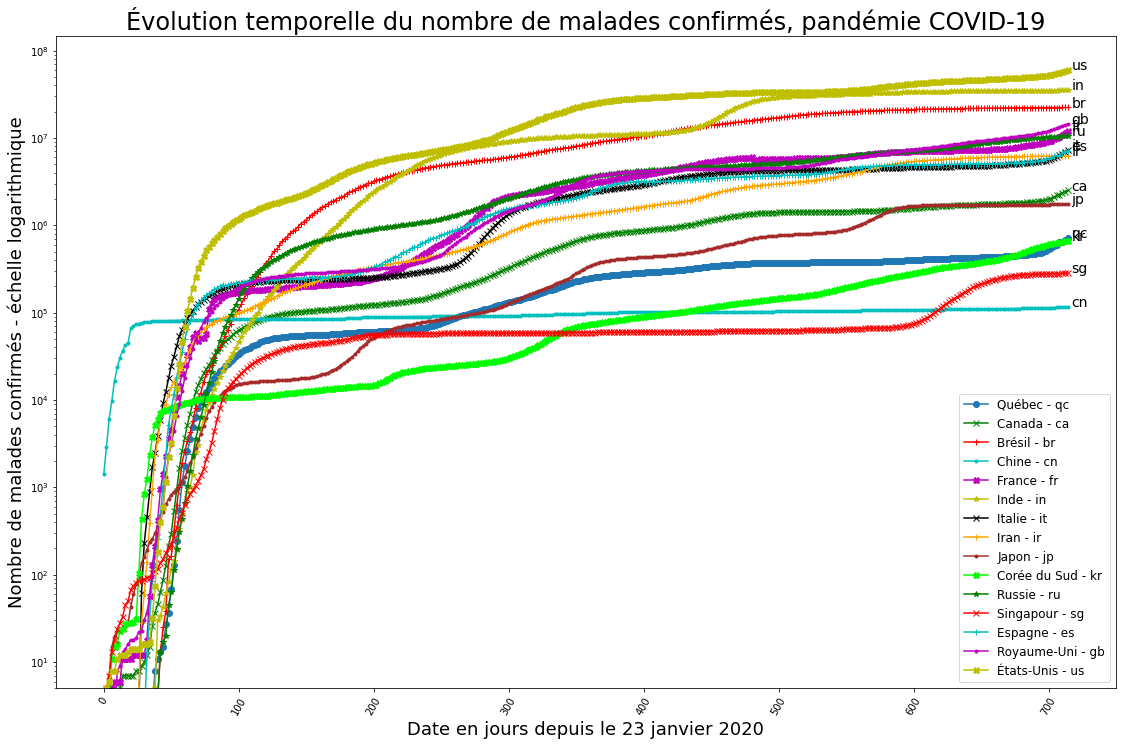

In [520]:
import itertools
from random import randrange

nombre_dor = 1.618
hauteur = 12
longueur = int(nombre_dor * hauteur)
fig, ax = plt.subplots(figsize=(longueur,hauteur))


# https://stackoverflow.com/questions/13091649/unique-plot-marker-for-each-plot-in-matplotlib
marqueurs = itertools.cycle(('x', '+', '.', 'X', '*'))
couleurs = itertools.cycle(('g', 'r', 'c', 'm', 'y', 'k', 'orange', 'brown', 'lime'))

import matplotlib.colors as pltcol

regions = ['Québec', 'Canada', 'Brazil', 'China', 'France', 'India', 'Italy', 'Iran', 'Japan',
           'Korea, South', 'Russia', 'Singapore', 'Spain', 'United Kingdom', 'US']

etiquettes = {'Québec':'Québec', 'Canada':'Canada', 'Brazil':'Brésil', 'China':'Chine', 'France':'France', 
              'India':'Inde','Italy':'Italie', 'Iran':'Iran','Japan':'Japon','Korea, South':'Corée du Sud',
              'Russia':'Russie','Singapore':'Singapour','Spain':'Espagne', 'Sweden':'Suède',
              'United Kingdom':'Royaume-Uni', 'US':'États-Unis'}

code_pays = { 
    'Québec':'qc', 'Canada':'ca', 'Brazil':'br','China':'cn', 'France':'fr', 'India':'in',
    'Italy':'it', 'Iran':'ir','Japan':'jp','Korea, South':'kr', 'Russia':'ru','Singapore':'sg', 
    'Spain':'es', 'Sweden':'se','United Kingdom':'gb', 'US':'us'
} 

for region in regions:
    if region == "Québec":
        marqueur = "o"
        couleur = "tab:blue"
    else:
        marqueur = next(marqueurs)
        couleur = next(couleurs)
    plt.plot(# Remplacer la date par le nombre de jours depuis le début de la pandémie
             # list(series_chronologiques_COVID19_df.columns[2:]),
             [2*i for i in range(0,series_chronologiques_COVID19_df.shape[1]-2)],
             list(series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']==region].iloc[0,2:]), 
             marker=marqueur, 
             color=couleur, 
             label=etiquettes[region]+" - "+code_pays[region])
    etiq_y_pos = series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']==region].iloc[0,-1]
    plt.text(nbr_jours-1, etiq_y_pos, code_pays[region],fontsize=14)    
plt.legend(loc='best',fontsize=12)
xticks(rotation=60)
ax.set_yscale('log')
ylim(bottom=5)
#xlim(right=60)

plt.title(u'Évolution temporelle du nombre de malades confirmés, pandémie COVID-19',fontsize=24)
plt.xlabel(u'Date en jours depuis le 23 janvier 2020',fontsize=18)
_ = plt.ylabel(u'Nombre de malades confirmés - échelle logarithmique',fontsize=18)
plt.savefig('images/Evolution-COVID19-EchLog.png')
plt.show()


#### Pour mieux apprécier le phénomène d'accroissement exponentiel

Pour mieux «voir» l'accroissement exponentiel, nous mettons en commentaire la ligne `ax.set_yscale('log')` qui définit l'échelle logarithmique en ordonnée (i.e. axe vertical). Nous revenons donc à une échelle linéaire.

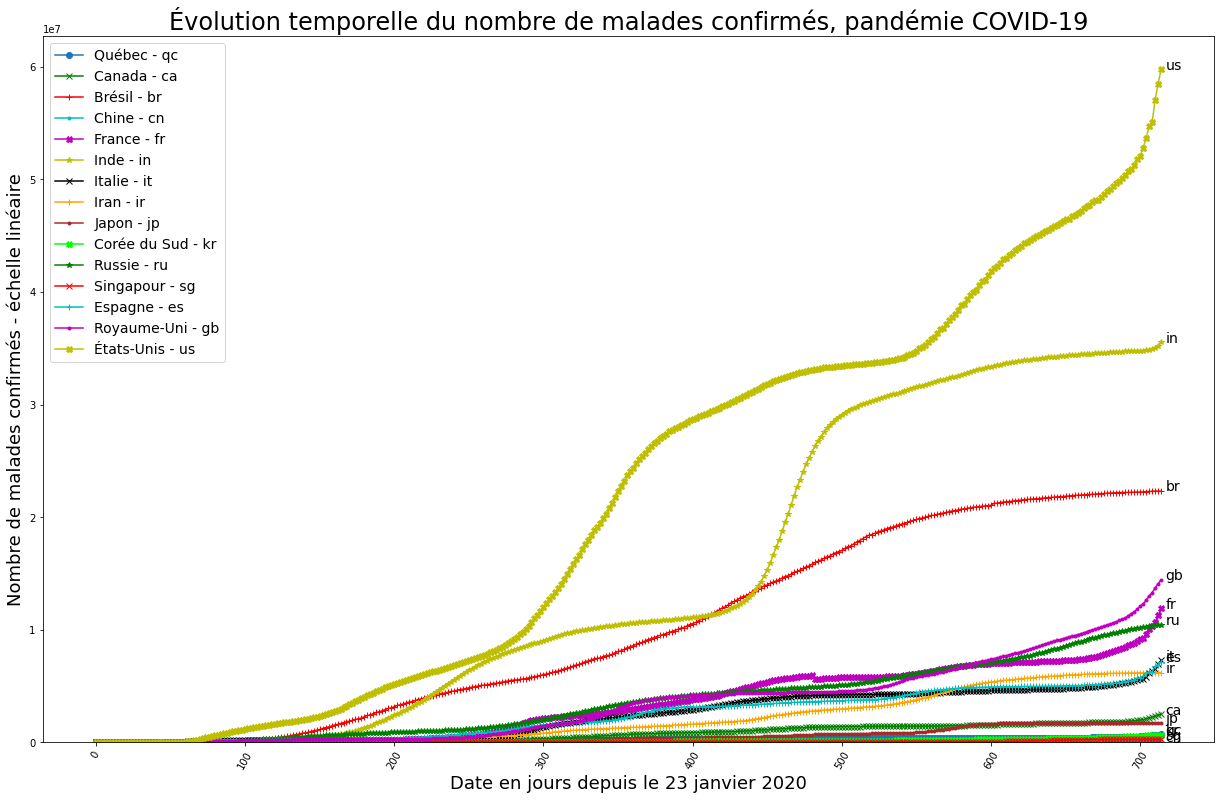

In [521]:
import itertools

nombre_dor = 1.618
hauteur = 13
longueur = int(nombre_dor * hauteur)
fig, ax = plt.subplots(figsize=(longueur,hauteur))
# https://stackoverflow.com/questions/13091649/unique-plot-marker-for-each-plot-in-matplotlib
marqueurs = itertools.cycle(('x', '+', '.', 'X', '*'))
couleurs = itertools.cycle(('g', 'r', 'c', 'm', 'y', 'k', 'orange', 'brown', 'lime'))

import matplotlib.colors as pltcol

regions = ['Québec', 'Canada', 'Brazil', 'China', 'France', 'India', 'Italy', 'Iran', 'Japan',
           'Korea, South', 'Russia', 'Singapore', 'Spain', 'United Kingdom', 'US']

etiquettes = {'Québec':'Québec', 'Canada':'Canada', 'Brazil':'Brésil', 'China':'Chine', 'France':'France', 
              'India':'Inde','Italy':'Italie', 'Iran':'Iran','Japan':'Japon','Korea, South':'Corée du Sud',
              'Russia':'Russie','Singapore':'Singapour','Spain':'Espagne', 'Sweden':'Suède',
              'United Kingdom':'Royaume-Uni', 'US':'États-Unis'}

code_pays = { 
    'Québec':'qc', 'Canada':'ca', 'Brazil':'br','China':'cn', 'France':'fr', 'India':'in',
    'Italy':'it', 'Iran':'ir','Japan':'jp','Korea, South':'kr', 'Russia':'ru','Singapore':'sg', 
    'Spain':'es', 'Sweden':'se','United Kingdom':'gb', 'US':'us'
} 

for region in regions:
    if region == "Québec":
        marqueur = "o"
        couleur = "tab:blue"
    else:
        marqueur = next(marqueurs)
        couleur = next(couleurs)
    plt.plot(# Remplacer la date par le nombre de jours depuis le début de la pandémie
             # list(series_chronologiques_COVID19_df.columns[2:]),
             [2*i for i in range(0,series_chronologiques_COVID19_df.shape[1]-2)], 
             list(series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']==region].iloc[0,2:]), 
             marker=marqueur, 
             color=couleur, 
             label=etiquettes[region]+" - "+code_pays[region])
    etiq_y_pos = series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']==region].iloc[0,-1]
    plt.text(nbr_jours-1, etiq_y_pos, code_pays[region],fontsize=14)    
plt.legend(loc='best',fontsize=14)
xticks(rotation=60)
#ax.set_yscale('log')
ylim(bottom=0)
plt.title(u'Évolution temporelle du nombre de malades confirmés, pandémie COVID-19',fontsize=24)
plt.xlabel(u'Date',fontsize=18)
plt.xlabel(u'Date en jours depuis le 23 janvier 2020',fontsize=18)
_ = plt.ylabel(u'Nombre de malades confirmés - échelle linéaire',fontsize=18)
plt.savefig('images/Evolution-COVID19-EchNormale.png')
plt.show()


## Analyse sommaire

On constate que les pays, comme la Chine, le Japon, Taïwan, la Corée du sud et Singapour, qui ont pris des mesures draconiennes de quarantaine et l'éloignement physique (la mal nommée distanciation sociale), ont réussi à contenir l'accroissement du nombre de cas. 

Au contraire, les pays qui ont tardé à réagir ou manqué de ressources comme l'Italie, l'Iran, les États-Unis, la France ou l'Espagne n'ont pas encore réussi à ralentir l'accroissement du nombre de malades. Pour le moment le Canada et le Québec se situent entre les deux, mais la tendance des derniers jours fait redouter une potentielle explosion du nombre de malades. Le talon d'Achille demeure les hôpitaux de soins de longue durée (CHSLD) et les résidences pour personnes âgées.

Signe encourageant, on constate une inflexion graduelle du taux d'augmentation au Québec, la courbe s'aplatit. Il est important de ne pas relâcher les mesures d'hygiène et d'isolement physique car il existe un risque de rebond. 

Par contre aux États-Unis on constate une recrudescence de l'épidémie au mois de juin 2020 alors que le Brésil ne voit même pas de fléchissement.

In [522]:
print("Exécution terminée!")

Exécution terminée!
